In [53]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [54]:
# load the data
df=pd.read_csv('Data/insurance.csv')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


#  Q1. Do smokers have higher insurance charges than non-smokers?

- Null Hypothesis: There is NO DIFFERENCE in insurance charges between smokers vs non-smokers.
- Alternative Hypothesis: There is a SIGNIFICANT DIFFERENCE in insurance charges between smokers vs non-smokers.

- Type of data: Numeric
- Test: 2 sample t-test
- Groups/Samples:
  - Smokers
  - Non-Smokers

In [55]:
# target column
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [56]:
# Separate the two groups
df['smokes'] = df['smoker'].str.contains('yes')
df['smokes'].value_counts()

False    1064
True      274
Name: smokes, dtype: int64

In [57]:
df['no_smoke'] = df['smoker'].str.contains('no')
df['no_smoke'].value_counts()

True     1064
False     274
Name: no_smoke, dtype: int64

In [58]:
# save list of columns needed for each group
needed_cols = ['charges','smokes']
df[needed_cols]

,charges,smokes
0,16884.92400,True
1,1725.55230,False
2,4449.46200,False
3,21984.47061,False
4,3866.85520,False
...,...,...
1333,10600.54830,False
1334,2205.98080,False
1335,1629.83350,False
1336,2007.94500,False


In [59]:
# save non_smoker_df in separate variable
non_smoker_df = df.loc[ df['smokes']==False, needed_cols]
non_smoker_df

,charges,smokes
1,1725.55230,False
2,4449.46200,False
3,21984.47061,False
4,3866.85520,False
5,3756.62160,False
...,...,...
1332,11411.68500,False
1333,10600.54830,False
1334,2205.98080,False
1335,1629.83350,False


In [60]:
# save smoker_df in separate variables
smoker_df = df.loc[ df['smokes']==True, needed_cols]
smoker_df

,charges,smokes
0,16884.92400,True
11,27808.72510,True
14,39611.75770,True
19,36837.46700,True
23,37701.87680,True
...,...,...
1313,36397.57600,True
1314,18765.87545,True
1321,28101.33305,True
1323,43896.37630,True


In [61]:
## Make a df just for visualization by concat the groups 
plot_df =  pd.concat([smoker_df,non_smoker_df])
plot_df

,charges,smokes
0,16884.9240,True
11,27808.7251,True
14,39611.7577,True
19,36837.4670,True
23,37701.8768,True
...,...,...
1332,11411.6850,False
1333,10600.5483,False
1334,2205.9808,False
1335,1629.8335,False


<AxesSubplot:xlabel='charges', ylabel='Count'>

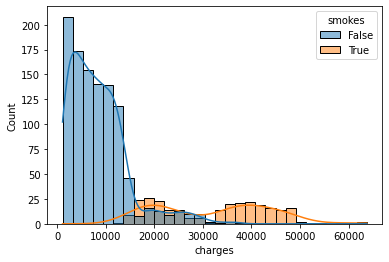

In [62]:
## visualize the group means
sns.histplot(data=plot_df, x='charges',kde=True, hue='smokes')

<AxesSubplot:xlabel='smokes', ylabel='charges'>

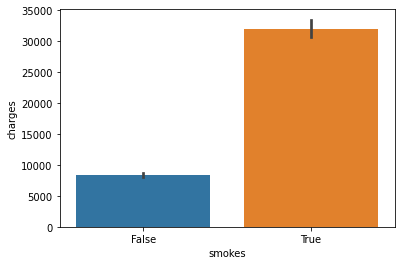

In [63]:
sns.barplot(data=plot_df, y='charges', x='smokes')

## T-Test Assumptions
- No significant outliers
- Normality
- Equal Variance

**Checking for outliers**

In [64]:
# Saving JUST the numeric col as final group variables
non_smoker_group = non_smoker_df['charges']
smoker_group = smoker_df['charges']

In [65]:
# Check smoker group for outliers
smoker_outliers = np.abs(stats.zscore(smoker_group))>3

#smoker_outliers.value_counts()
np.sum(smoker_outliers)

0

No outliers in smoker group

In [66]:
# Check non smoker group for outliers
non_smoker_outliers = np.abs(stats.zscore(non_smoker_group))>3

#smoker_outliers.value_counts()
np.sum(non_smoker_outliers)

24

In [67]:
# Remove 24 outliers found in non smoker group
non_smoker_group = non_smoker_group[~non_smoker_outliers]

**Testing for Normality**

In [68]:
# Check smoker group for normality
result = stats.normaltest(smoker_group)
result

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [69]:
# Check n for smoker group
len(smoker_group)

274

In [70]:
# Check non smoker group for normality
result = stats.normaltest(non_smoker_group)
result

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

In [71]:
# Check n for non smoker group
len(non_smoker_group)

1040

Both groups did not pass the normality test but they both do have a sample size greater than 20, therefore we can ignore the normality assumption.

**Testing for Equal Variances**

In [72]:
# Use Levene's test for equal variance
result = stats.levene(non_smoker_group,smoker_group)
result.pvalue<.05

True

In [73]:
# Use an if-else to help interpret the p-value
if result.pvalue <.05:
    print('The groups DO NOT have equal variance')
else:
    print('The groups DO have equal variance')

The groups DO NOT have equal variance


**Final Test/Hypothesis**

Since it failed the assumption of equal variance, I used the Welch's T-Test and added equal_var=False to ttest_ind.

In [74]:
# run final hypothesis test
result = stats.ttest_ind(smoker_group,non_smoker_group,equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

In [75]:
print(result.pvalue<.0000001)

True


In [76]:
# Compare means for both groups
smoker_group.mean()

32050.23183153284

In [77]:
non_smoker_group.mean()

7939.8608446721155

     -In conclusion, the p-value was < .05 for our welch's t-test. We reject the null hypothesis and support the alternative that there is a significance difference in chargers fir smokers and non-smokers.

# Q2. Are men more likely to smoke than women?

- Null Hypothesis: There is NO DIFFERENCE in what gender is more likely to smoke.
- Alternative Hypothesis: There is a SIGNIFICANT DIFFERENCE in what gender is more likely to smoke.

- Type of data: categorical
- Test: Chi Squared Test
- Groups/Samples: 
  - 2 samples
  - Comparing which gender is more likely to smoke

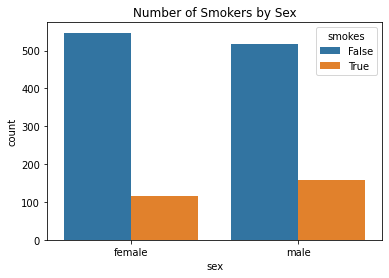

In [78]:
ax = sns.countplot(data=df, x='sex',hue='smokes',)
ax.set_title("Number of Smokers by Sex");

In [79]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smokes'])
table

smokes,False,True
sex,,
female,547,115
male,517,159


In [80]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

In [81]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

In conclusion,our p-value was < alpha, therefore we reject the null hypothesis that there is no relationship between a gender and smoking status.

# Q3. Do different regions have different charges, on average?

- Null Hypothesis: There is NO DIFFERENCE in charges between regions. 
- Alternative Hypothesis: There is a SIGNIFICANT DIFFERENCE in chargers between regions 

- Type of data: numerical
- Test: ANOVA
- Groups/Samples:
  - Results of different charges in different regions

## One Way ANOVA assumptions

- No significant outliers
- Equal variance
- Normality

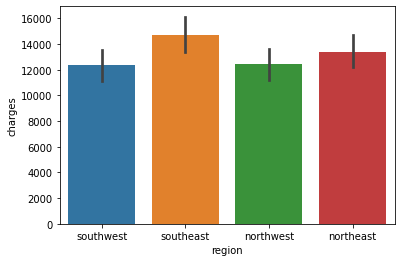

In [82]:
sns.barplot(data=df, x='region',y='charges');

In [83]:
# Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

**Assumption of Normality**

In [84]:
# Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
# convert to a df
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [85]:
# checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


**Testing Assumption of Equal Variance**

In [86]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

We did not met the assumption of equal variance.

**Final Test**

In [87]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

**Tukey's Pairwise Multiple Comparison test**

In [88]:
# save the values as charges and the labels to the region
values = df['charges']
labels = df['region']

In [89]:
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


In conclusion, there is one significant result between southeast and southwest.